In [1]:
# Install dependencies for computer vision and detection
!pip install torch torchvision --quiet
!pip install opencv-python mediapipe facenet-pytorch --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.

In [3]:
import torch
import cv2
import numpy as np
import mediapipe as mp
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [8]:
#upload video
from google.colab import files
uploaded = files.upload()

# Get the filename (works if you upload one file)
video_filename = next(iter(uploaded))
print("Video file uploaded as:", video_filename)


Saving my_webcam_video.mp4.mov to my_webcam_video.mp4.mov
Video file uploaded as: my_webcam_video.mp4.mov


In [9]:
#set device for inference

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

mtcnn = MTCNN(keep_all=True, device=device)

Using device: cpu


Total frames: 400


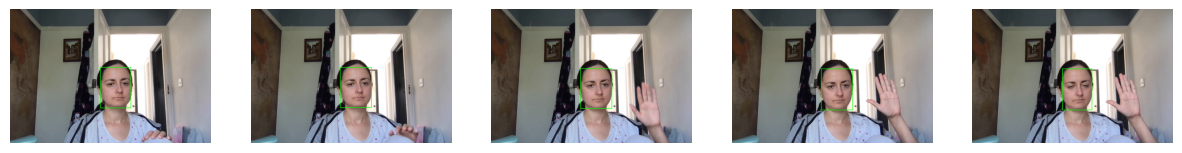

In [11]:
#Stage 1: face detection in the uploaded video
#open the uploaded video

video = cv2.VideoCapture(video_filename)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames: {frame_count}")

detected_frames = []
frames_to_show = 5

for idx in range(frame_count):
    ret, frame = video.read()
    if not ret:
        break
    if idx %10 !=0:
      continue

    #Convert frame (OpenCV uses BGR, but facenet-pytorch expects RGB)
    rgb_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    boxes, _ = mtcnn.detect(rgb_frame)

    #draw boxes if faces detected
    if boxes is not None:
      for box in boxes:
          box = [int(b) for b in box]
          cv2.rectangle(frame, (box[0],box[1]), (box[2],box[3]), (0,255,0), 2)

    if len(detected_frames) < frames_to_show:
      detected_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

video.release()

# show sample of frames with detected faces
fig, axes = plt.subplots(1, frames_to_show, figsize=(15, 5))
for ax, img in zip(axes, detected_frames):
    ax.imshow(img)
    ax.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


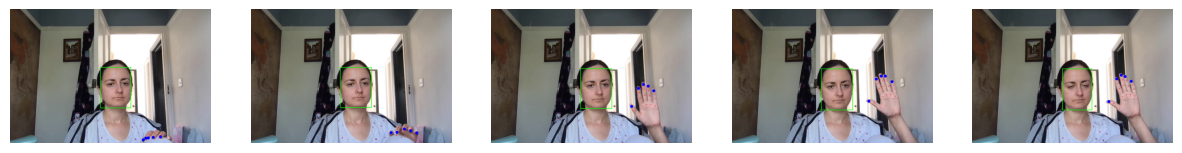

In [14]:
#Stage 2: Add hand and finger detection:

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Re-open your video
video = cv2.VideoCapture(video_filename)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

detected_frames = []
frames_to_show = 5

for idx in range(frame_count):
    ret, frame = video.read()
    if not ret:
        break
    if idx % 10 != 0:
        continue  # For speed

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # --- Face detection ---
    boxes, _ = mtcnn.detect(rgb_frame)
    if boxes is not None:
        for box in boxes:
            box = [int(b) for b in box]
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)

    # --- Hand detection ---
    results = hands.process(rgb_frame)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for idx_lm, lm in enumerate(hand_landmarks.landmark):
                h, w, _ = frame.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                if idx_lm in [4,8,12,16,20]:
                    cv2.circle(frame, (cx, cy), 8, (255,0,0), -1)  # Blue circles for fingertips
                else:
                    cv2.circle(frame, (cx, cy), 2, (0,0,255), -1)  # Red dots for other points

    #save for visualisation
    if len(detected_frames) < frames_to_show:
        detected_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

video.release()
hands.close()

fig, axes = plt.subplots(1, len(detected_frames), figsize=(15,5))
for ax, img in zip(axes, detected_frames):
    ax.imshow(img)
    ax.axis('off')
plt.show()


/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


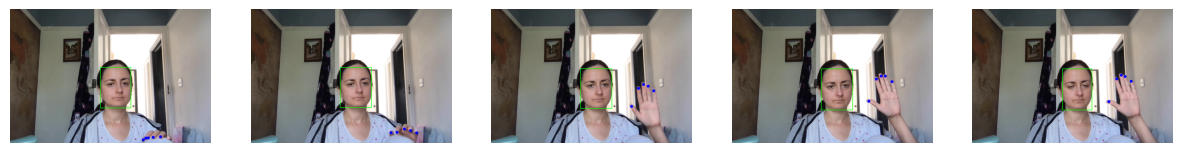

Total face touch events detected: 19
Sample events: [{'frame': 70, 'fingertip': 8, 'position': (646, 455)}, {'frame': 80, 'fingertip': 8, 'position': (643, 462)}, {'frame': 130, 'fingertip': 4, 'position': (670, 537)}, {'frame': 140, 'fingertip': 8, 'position': (663, 488)}, {'frame': 210, 'fingertip': 8, 'position': (664, 521)}]


In [15]:
# Stage 3: Face-touch detection logic

# Set up MediaPipe Hands (again, if needed)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

video = cv2.VideoCapture(video_filename)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

touch_events = []
detected_frames = []
frames_to_show = 5
touch_count = 0

for idx in range(frame_count):
    ret, frame = video.read()
    if not ret:
        break
    if idx % 10 != 0:
        continue  # For speed

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    boxes, _ = mtcnn.detect(rgb_frame)

    # Prepare variables for detection
    face_box = None
    if boxes is not None:
        face_box = [int(b) for b in boxes[0]]  # Only consider first face (modify if more)
        # Draw face box
        cv2.rectangle(frame, (face_box[0], face_box[1]), (face_box[2], face_box[3]), (0,255,0), 2)

    # Hand detection
    results = hands.process(rgb_frame)
    fingertip_indices = [4,8,12,16,20]  # Thumb, Index, Middle, Ring, Pinky
    if results.multi_hand_landmarks and face_box is not None:
        for hand_landmarks in results.multi_hand_landmarks:
            for idx_tip in fingertip_indices:
                lm = hand_landmarks.landmark[idx_tip]
                h, w, _ = frame.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                # Draw fingertips
                cv2.circle(frame, (cx, cy), 8, (255,0,0), -1)
                # Check if fingertip is inside face bounding box
                if (face_box[0] <= cx <= face_box[2]) and (face_box[1] <= cy <= face_box[3]):
                    touch_count += 1
                    touch_events.append({'frame': idx, 'fingertip': idx_tip, 'position': (cx,cy)})
                    # Mark touch with a YELLOW circle
                    cv2.circle(frame, (cx, cy), 10, (0,255,255), 3)

    # Save for visualization
    if len(detected_frames) < frames_to_show:
        detected_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

video.release()
hands.close()

# Show frames with overlays
fig, axes = plt.subplots(1, len(detected_frames), figsize=(15, 5))
if len(detected_frames) == 1:
    axes = [axes]
for ax, img in zip(axes, detected_frames):
    ax.imshow(img)
    ax.axis('off')
plt.show()

print(f"Total face touch events detected: {touch_count}")

# Optional: show the frames/times where a touch occurred
print("Sample events:", touch_events[:5])

